In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import math
import scipy as sp
from statsmodels import regression
import xlsxwriter
import random
import datetime

import sqlite3
from sqlite3 import Error
from collections import OrderedDict


# Data Preparation

In [94]:
pd.set_option("display.precision", 8)

#Load data from Excel into a dataframe
data = pd.read_excel('Data.xlsx', index_col=0, skiprows=0)
data.dropna(axis = 0,inplace= True)

# Format dates column in dataframe for SQL storage
data.index = pd.to_datetime(data.index, format='%Y-%m-%d').strftime('%Y-%m-%d %H-%M-%S')
data.head(5)

,SMI Index,CCMP Index,DAX Index,UKX Index,EURUSD Curncy,CHFEUR Curncy,CHFUSD Curncy,CL1 Comdty,XAU Comdty,XAG Comdty,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
Dates,,,,,,,,,,,,,,,,,,,,
2011-01-31 00-00-00,6479.15,2700.08,7077.48,5862.94,1.3698,0.7760,1.0628,92.19,1337.14,28.3900,0.3,58.3,57.6,0.8,8823.2,99.2,54.9,3.3704,74.2,64.79
2011-02-28 00-00-00,6610.44,2782.27,7272.32,5994.01,1.3792,0.7800,1.0758,96.97,1411.88,33.8894,0.3,58.4,58.0,0.8,8887.0,100.1,54.3,3.4272,77.5,72.02
2011-03-31 00-00-00,6357.55,2781.07,7041.31,5908.76,1.4190,0.7695,1.0920,106.72,1437.78,37.7175,0.5,58.4,55.8,0.9,8943.4,100.3,55.2,3.4703,67.5,63.82
2011-04-29 00-00-00,6539.70,2873.54,7514.46,6069.90,1.4807,0.7804,1.1557,113.93,1563.70,47.9050,0.5,58.4,55.2,0.5,9004.9,99.8,53.8,3.2863,69.8,66.02
2011-05-31 00-00-00,6554.71,2835.30,7293.69,5989.99,1.4369,0.8156,1.1718,102.70,1536.23,38.1738,0.3,58.3,55.0,0.0,9075.5,100.4,52.1,3.0607,74.3,61.74


# Data Processing - Split data into 4 subsets

In [95]:
# Create smaller datasets by selecting dates from the index
sample_1 = data[0:30] # 01.01.2011 - 28.06.2013
sample_2 = data[30:60] # 01.07.2013 - 31.12.2015
sample_3 = data[60:90] # 01.01.2016 - 29.06.2018
sample_4 = data[90:120] # 01.07.2018 - 31.12.2020
dataSets = [sample_1, sample_2, sample_3, sample_4]


# Transform dataframe of subsets into a list so it can be inserted into a SQL database
recordsSample1 = sample_1.reset_index().values.tolist()
recordsSample2 = sample_2.reset_index().values.tolist()
recordsSample3 = sample_3.reset_index().values.tolist()
recordsSample4 = sample_4.reset_index().values.tolist()
recordsSample1


[['2011-01-31 00-00-00',
  6479.15,
  2700.08,
  7077.48,
  5862.94,
  1.3698000000000001,
  0.776,
  1.0628,
  92.19,
  1337.14,
  28.39,
  0.3,
  58.3,
  57.6,
  0.8,
  8823.2,
  99.2,
  54.9,
  3.3704,
  74.2,
  64.79],
 ['2011-02-28 00-00-00',
  6610.44,
  2782.27,
  7272.32,
  5994.01,
  1.3792,
  0.78,
  1.0758,
  96.97,
  1411.88,
  33.8894,
  0.3,
  58.4,
  58.0,
  0.8,
  8887.0,
  100.1,
  54.3,
  3.4272,
  77.5,
  72.02],
 ['2011-03-31 00-00-00',
  6357.55,
  2781.07,
  7041.31,
  5908.76,
  1.419,
  0.7695,
  1.092,
  106.72,
  1437.78,
  37.7175,
  0.5,
  58.4,
  55.8,
  0.9,
  8943.4,
  100.3,
  55.2,
  3.4703,
  67.5,
  63.82],
 ['2011-04-29 00-00-00',
  6539.7,
  2873.54,
  7514.46,
  6069.9,
  1.4807000000000001,
  0.7804,
  1.1557,
  113.93,
  1563.7,
  47.905,
  0.5,
  58.4,
  55.2,
  0.5,
  9004.9,
  99.8,
  53.8,
  3.2862999999999998,
  69.8,
  66.02],
 ['2011-05-31 00-00-00',
  6554.71,
  2835.3,
  7293.69,
  5989.99,
  1.4369,
  0.8156,
  1.1718,
  102.7,
  1536.2

# SQL Connection

## Check main connection to SQL

In [96]:
""" create a database connection tool to a SQLite database """

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
 
 
if __name__ == '__main__':
    create_connection(r"database.db")



2.6.0


## SQL - Create tables for subsets and results

In [97]:
def createTableSample(tableName):
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists ''' + tableName + '''
             (id INTEGER PRIMARY KEY,
             Dates TIMESTAMP,
             SMI           INT    NOT NULL,
             CCMP            INT     NOT NULL,
             DAX INT NOT NULL,
             UKX INT NOT NULL,
             EURUSD INT NOT NULL,
             CHFEUR INT NOT NULL,
             CHFUSD INT NOT NULL,
             CL1 INT NOT NULL,
             XAU INT NOT NULL,
             XAG INT NOT NULL,
             CPI CHNG INT NOT NULL,
             USERTOT INT NOT NULL,
             NAPMNMI INT NOT NULL,
             RSTAMOM INT NOT NULL,
             M2 INT NOT NULL,
             EUITEMU INT NOT NULL,
             PMINORD INT NOT NULL,
             USGG10YR INT NOT NULL,
             CONSSENT INT NOT NULL,
             CONCCONF INT)''')
    print('Table', tableName, 'created successfully')
    
def storeDataTableSample(tableName, records):
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.executemany('INSERT INTO ' + tableName + '(Dates,SMI,CCMP,DAX,UKX,EURUSD,CHFEUR,CHFUSD,CL1,XAU,XAG,CPI,USERTOT,NAPMNMI,RSTAMOM,M2,EUITEMU,PMINORD,USGG10YR,CONSSENT,CONCCONF) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', records) 
    conn.commit()
    print('Data successfully inserted into table', tableName)

createTableSample('Sample1')
createTableSample('Sample2')
createTableSample('Sample3')
createTableSample('Sample4')

storeDataTableSample('Sample1', recordsSample1)
storeDataTableSample('Sample2', recordsSample2)
storeDataTableSample('Sample3', recordsSample3)
storeDataTableSample('Sample4', recordsSample4)


Table Sample1 created successfully
Table Sample2 created successfully
Table Sample3 created successfully
Table Sample4 created successfully
Data successfully inserted into table Sample1
Data successfully inserted into table Sample2
Data successfully inserted into table Sample3
Data successfully inserted into table Sample4


# Store Descriptiv Statistic of data sets

In [98]:
# Store in database
sample_1.describe()
sample_2.describe()
sample_3.describe()
sample_4.describe()

,SMI Index,CCMP Index,DAX Index,UKX Index,EURUSD Curncy,CHFEUR Curncy,CHFUSD Curncy,CL1 Comdty,XAU Comdty,XAG Comdty,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
count,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000,30.00000000
mean,9744.96400000,8826.97633333,12114.21833333,6830.44133333,1.13614000,0.90998333,1.03376333,50.72666667,1518.28866667,17.79993000,0.14333333,59.11666667,55.77666667,0.35333333,15856.89333333,100.69000000,50.47000000,1.74843000,90.63000000,118.35666667
std,577.41683142,1617.06125322,873.57878987,667.78051518,0.03396621,0.02440263,0.03897687,13.02946114,252.26468222,3.90993074,0.24730734,2.70237231,3.88318065,4.95919441,1752.45241422,7.06898764,4.17423542,0.89217549,10.03432557,18.20863159
min,8429.30000000,6635.28000000,9935.84000000,5577.27000000,1.09030000,0.86320000,0.98160000,18.84000000,1192.52000000,14.03740000,-0.70000000,51.30000000,41.60000000,-14.70000000,14159.40000000,74.50000000,29.30000000,0.52820000,71.80000000,85.70000000
25%,9331.17500000,7707.40500000,11533.65000000,6193.85250000,1.11077500,0.88882500,1.00510000,43.14750000,1295.68000000,14.97625000,0.02500000,57.40000000,55.15000000,-0.20000000,14501.52500000,100.02500000,49.90000000,0.84760000,80.97500000,101.32500000
50%,9831.26000000,8142.48000000,12278.83000000,7101.41500000,1.12745000,0.91430000,1.02150000,53.64500000,1491.47500000,16.50745000,0.20000000,60.55000000,56.50000000,0.35000000,15093.40000000,103.55000000,51.25000000,1.73340000,95.85000000,126.45000000
75%,10121.25000000,9405.13750000,12794.30750000,7392.79000000,1.16035000,0.92947500,1.03965000,58.55250000,1719.62000000,18.17942500,0.20000000,60.77500000,57.20000000,0.77500000,17680.47500000,104.92500000,52.00000000,2.59742500,98.37500000,131.37500000
max,10703.51000000,12888.28000000,13718.78000000,7748.76000000,1.22250000,0.94610000,1.13020000,73.25000000,1975.86000000,28.28700000,0.50000000,61.10000000,60.90000000,18.10000000,19125.80000000,106.10000000,53.90000000,3.14350000,101.00000000,137.90000000


In [256]:
# Pivot table of dataframe 
sample_3.pivot

<bound method DataFrame.pivot of                      SMI Index  CCMP Index  DAX Index  UKX Index  \
Dates                                                              
2016-01-29 00-00-00    8319.81     4613.95    9798.11    6083.79   
2016-02-29 00-00-00    7843.63     4557.95    9495.40    6097.09   
2016-03-31 00-00-00    7807.89     4869.85    9965.51    6174.90   
2016-04-29 00-00-00    7960.85     4775.36   10038.97    6241.89   
2016-05-31 00-00-00    8216.42     4948.06   10262.74    6230.79   
2016-06-30 00-00-00    8020.15     4842.67    9680.09    6504.33   
2016-07-29 00-00-00    8127.20     5162.13   10337.50    6724.43   
2016-08-31 00-00-00    8202.13     5213.22   10592.69    6781.51   
2016-09-30 00-00-00    8139.01     5312.00   10511.02    6899.33   
2016-10-31 00-00-00    7827.74     5189.14   10665.01    6954.22   
2016-11-30 00-00-00    7875.19     5323.68   10640.30    6783.79   
2016-12-30 00-00-00    8219.87     5383.12   11481.06    7142.83   
2017-01-31 00-0

# Normality Test - Create Histograms

In [249]:
for col in data.iteritems(): 
    print('histogram'+col[0])
    fig, ax = plt.subplots()
    indicator=data[col[0]]
    ax.hist(indicator, alpha=0.9, color='blue',bins=20)
    plt.title(col[0])
    plt.savefig('Charts/Hist_'+col[0]+'.png')
    plt.close()

histogramSMI Index
histogramCCMP Index
histogramDAX Index
histogramUKX Index
histogramEURUSD Curncy
histogramCHFEUR Curncy
histogramCHFUSD Curncy
histogramCL1 Comdty
histogramXAU Comdty
histogramXAG Comdty
histogramCPI CHNG Index
histogramUSERTOT Index
histogramNAPMNMI Index
histogramRSTAMOM Index
histogramM2 Index
histogramEUITEMU Index
histogramCPMINORD Index
histogramUSGG10YR Index
histogramCONSSENT Index
histogramCONCCONF Index
histogramconst


# Stationary Test

In [99]:
# Add every column name in a new list
columns = data.columns.tolist()
# Separate asset and macro data
assetColumns = columns[:10]
macroColumns = columns[10:20]

for i in range(len(dataSets)):
    print('Subset', i + 1, '\n')
    print('------------------------')
    for j in assetColumns:
        # ADF Test with 1 lag and constant regression model
        stationaryResult = adfuller(dataSets[i][j])
        if (stationaryResult[1] < 0.1):
            print(j, 'is stationary, because p-value of', stationaryResult[1], 'is < 0.1 --> 90% significant')
        else:
            print(j, 'is NOT stationary, because p-value of', stationaryResult[1], 'is >= 0.1')
    print('------------------------ \n')

Subset 1 

------------------------
(0.028741811031937077, 0.9608454461116381, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 270.85831943462915)
SMI Index is NOT stationary, because p-value of 0.9608454461116381 is >= 0.1
(-0.6757596076159192, 0.8529288385236653, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 245.23947374524306)
CCMP Index is NOT stationary, because p-value of 0.8529288385236653 is >= 0.1
(-1.1798092640516964, 0.6822203990826865, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 282.09321731656576)
DAX Index is NOT stationary, because p-value of 0.6822203990826865 is >= 0.1
(-1.3954991723853047, 0.5844319596144637, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 266.0241439800854)
UKX Index is NOT stationary, because p-value of 0.5844319596144637 is >= 0.1
(-1.6152501323085313, 0.4752203331919417, 0

(-1.9666768555888618, 0.30137248867215927, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 140.87173549846423)
CL1 Comdty is NOT stationary, because p-value of 0.30137248867215927 is >= 0.1
(2.4414754710129385, 0.9990285106264699, 9, 20, {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}, 227.51318635202816)
XAU Comdty is NOT stationary, because p-value of 0.9990285106264699 is >= 0.1
(-0.5927375168633193, 0.872614620566071, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 94.30334644876012)
XAG Comdty is NOT stationary, because p-value of 0.872614620566071 is >= 0.1
------------------------ 



# Chow Test - Function

In [109]:
def chowTest(regressionArray, xArray, regressionGroupId):
    
    # Whole time series
    RSSd = regressionArray[0].ssr

    # Sample 1 --> subset 1
    RSSb1 = regressionArray[1].ssr
 
    # Sample 2 --> subset 2
    RSSb2 = regressionArray[2].ssr

    # Sample 3 --> subset 3
    RSSb3 = regressionArray[3].ssr

    # Sample 4 --> subset 4
    RSSb4 = regressionArray[4].ssr
    
    #J-Variable (1)
    J = xArray[0].shape[1] #one for all

    #k-Variables (4)
    k1 = xArray[1].shape[1] #Sample 1
    k2 = xArray[2].shape[1] #Sample 2
    k3 = xArray[3].shape[1] #Sample 3
    k4 = xArray[4].shape[1] #Sample 4

    #N1-Variables (4)
    N1 = xArray[1].shape[0] #Sample 1
    N2 = xArray[2].shape[0] #Sample 2
    N3 = xArray[3].shape[0] #Sample 3
    N4 = xArray[4].shape[0] #Sample 4
    
    # Regression Subset 1 + 2
    
    chow1 = ((RSSd-(RSSb1+RSSb2))/J)/((RSSb1+RSSb2)/(N1+N2-2*k1))
    chow1 = sp.stats.f.cdf(chow1, J, N1+N2-2*k1)
    
    # Regression Subset 2 + 3
    
    chow2 = ((RSSd-(RSSb2+RSSb3))/J)/((RSSb2+RSSb3)/(N2+N3-2*k2))
    chow2 = sp.stats.f.cdf(chow2, J, N2+N3-2*k2)

    # Regression Subset 3 + 4
    
    chow3 = ((RSSd-(RSSb3+RSSb4))/J)/((RSSb3+RSSb4)/(N3+N4-2*k3))
    chow3 = sp.stats.f.cdf(chow3, J, N3+N4-2*k3)

    # Regression Subset 1 + 3
    
    chow4 = ((RSSd-(RSSb1+RSSb3))/J)/((RSSb1+RSSb3)/(N1+N3-2*k1))
    chow4 = sp.stats.f.cdf(chow4, J, N1+N3-2*k1)

    # Regression Subset 1 + 4
    
    chow5 = ((RSSd-(RSSb1+RSSb4))/J)/((RSSb1+RSSb4)/(N1+N4-2*k1))
    chow5 = sp.stats.f.cdf(chow5, J, N1+N4-2*k1)

    # Regression Subset 2 + 4
    
    chow6 = ((RSSd-(RSSb2+RSSb4))/J)/((RSSb2+RSSb4)/(N2+N4-2*k2))
    chow6 = sp.stats.f.cdf(chow6, J, N2+N4-2*k2)

    print("Chow Test - Regression Model Subset 1 + 2:", chow1)
    print("Chow Test - Regression Model Subset 2 + 3:", chow2)
    print("Chow Test - Regression Model Subset 3 + 4:", chow3)
    print("Chow Test - Regression Model Subset 1 + 3:", chow4)
    print("Chow Test - Regression Model Subset 1 + 4:", chow5)
    print("Chow Test - Regression Model Subset 2 + 4:", chow6)
    
    chowResults = np.array([chow1,chow2,chow3,chow4,chow5,chow6,regressionGroupId])
    # storeChowTestResult(chowResults.tolist())
    

# Rolling Regression - Function

In [101]:
def rolling_regression(y, x, window):
    estimate_data = []
    for i in range(window, x.index.size+1):
        x_slice = x.values[i-window:i,:] # always index in np as opposed to pandas, much faster
        y_slice = y.values[i-window:i]
        coeff = np.dot(np.dot(np.linalg.inv(np.dot(x_slice.T, x_slice)), x_slice.T), y_slice)
        estimate_data.append(coeff[0] * x.values[window-1] + coeff[1])
        # === Assemble ========================================================
    estimate = pd.Series(data=estimate_data, index=x.index[window-1:]) 
    return estimate

# Multiple Linear Regression Model - OLS

## Regression - SQL preparation

In [102]:
def createTableRegression():
    conn = sqlite3.connect(r"database.db")
    conn.execute("PRAGMA foreign_keys = 1")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists RegressionModelResult
             (
             id INTEGER PRIMARY KEY,
             asset varchar,
             subset int,
             const INT,
             beta1 float,
             x1 varchar,
             beta2 float,
             x2 varchar,
             beta3 float,
             x3 varchar,
             beta4 float,
             x4 varchar,
             beta5 float,
             x5 varchar,
             rsquared float,
             observation int,
             regressionGroupId INTEGER,
             FOREIGN KEY (regressionGroupId) REFERENCES RegressionModelResultGroup(id))''')
    print('Table RegressionModelResult created successfully')

def createTableRegressionGroup():
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists RegressionModelResultGroup
             (
             id INTEGER PRIMARY KEY,
             assetName varchar)''')
    print('Table RegressionModelResultGroup created successfully')

def storeRegressionGroup(assetName):
    id = str(uuid.uuid4()).replace('-','')
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('INSERT INTO RegressionModelResultGroup(assetName) VALUES (\''+assetName+'\')') 
    conn.commit()
    print('Data successfully inserted into RegressionModelResultGroup table')
    return c.lastrowid

def storeRegressionModel(olsResult, asset, subset, regressionGroupId):
    xVars = olsResult.params.index
    rsquared = olsResult.rsquared
    ssr = olsResult.ssr
    nrOfObservations = olsResult.nobs
    
    # Beta 0
    const = olsResult.params[0]
    
    # Beta's of x variables
    b1 = olsResult.params[1]
    b2 = olsResult.params[2]
    b3 = olsResult.params[3]
    b4 = olsResult.params[4]
    b5 = olsResult.params[5]
    
    # x variable names
    x1 = xVars[1]
    x2 = xVars[2]
    x3 = xVars[3]
    x4 = xVars[4]
    x5 = xVars[5]
    
    regressionRecord = np.array([asset, subset, const, b1, x1, b2, x2, b3, x3, b4, x4, b5, x5, rsquared, nrOfObservations, regressionGroupId])
    print(regressionRecord)
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('INSERT INTO RegressionModelResult(asset,subset,const,beta1,x1,beta2,x2,beta3,x3,beta4,x4,beta5,x5,rsquared,observation,regressionGroupId) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', regressionRecord) 
    conn.commit()
    print('Data successfully inserted into RegressionModelResult table')
    return c.lastrowid

createTableRegressionGroup()
createTableRegression()

Table RegressionModelResultGroup created successfully
Table RegressionModelResult created successfully


## Chow Test - SQL Preparation 

In [103]:
def createTableChowTestResult():
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists ChowTestResult
         (
         id INTEGER PRIMARY KEY,
         chowTest1 float,
         chowTest2 float,
         chowTest3 float,
         chowTest4 float,
         chowTest5 float,
         chowTest6 float,
         regressionGroupId INTEGER,
         FOREIGN KEY (regressionGroupId) REFERENCES RegressionModelResultGroup(id))''')


    print("Table created successfully")
    
def storeChowTestResult(record):
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute("INSERT INTO ChowTestResult(chowTest1,chowTest2,chowTest3,chowTest4,chowTest5,chowTest6,regressionGroupId) VALUES (?,?,?,?,?,?,?)", record) 
    conn.commit()
    print('Successful ChowTest stored')

createTableChowTestResult()

Table created successfully


## Rolling Regrssion - SQL Preparation

In [104]:
def createTableRollingRegressionResult():
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists RollingRegressionResult
         (
         id INTEGER PRIMARY KEY,
         date TIMESTAMP,
         beta1 float,
         beta2 float,
         beta3 float,
         beta4 float,
         beta5 float,
         regressionId INTEGER,
         FOREIGN KEY (regressionId) REFERENCES RegressionModelResult(id))''')


    print("Table created successfully")
    
def storeRollingRegressionResult(records):
    conn = sqlite3.connect(r"database.db")
    c = conn.cursor()
    c.executemany("INSERT INTO RollingRegressionResult(date,beta1,beta2,beta3,beta4,beta5,regressionId) VALUES (?,?,?,?,?,?,?)", records) 
    conn.commit()
    print('Successful RollingRegression stored')
    
createTableRollingRegressionResult()

Table created successfully


## Run Main Model

In [110]:
index = 1
nrOfCharts = 0

while index <= 5:
    # Select sample of independent marco variables
    independVarColumns = random.sample(macroColumns, k=5)
    print(independVarColumns)
    for i in assetColumns:
        regressionModels = []
        xVars = []
        
        # OLS of whole time series
        mDependVar = data[i]
        mIndependVar = data[independVarColumns]
        mX = sm.add_constant(mIndependVar)
        mModel = sm.OLS(mDependVar, mX, missing='drop')
        mResult = mModel.fit()
    
        regressionModels.append(mResult)
        xVars.append(mX)
        # regressionGroupId = storeRegressionGroup(i)
        # OLS of each subset
        for j in range(len(dataSets)):
            
            # Y is depending variable. Depending variable get selected from the according subset.
            dependVar = dataSets[j][i]
            
            # X are the independed variables. Variables get selected from the according subset.
            independVar = dataSets[j][independVarColumns]
            
            print('\n')
            print('Subset:', j + 1)
            print('Y =', i)
            print('x variables:', independVarColumns)
            
            
            # Multivariate OLS generation
            x = sm.add_constant(independVar)
            model = sm.OLS(dependVar, x, missing='drop')
            results = model.fit()
            
            # Store Regression model in SQL
            # regressionId = storeRegressionModel(results, i, j+1, regressionGroupId)
            
            # Rolling Regression Calculation
            rollingOls = rolling_regression(dependVar,independVar,20)
            rollingOls=pd.DataFrame.from_dict(OrderedDict(rollingOls), orient='index')
            rollingOls['regressionId'] = regressionId
            rollingOls.columns=["Beta_1","Beta_2","Beta_3", "Beta_4", "Beta_5", "RegressionId"]
            print(rollingOls)
            
            # storeRollingRegressionResult(rollingOls.reset_index().values.tolist())
            
            # Store OLS regression model in array for upcoming chow test. 
            regressionModels.append(results)
            # Store the used independend variables in array for upcoming chow test.
            xVars.append(x)
            
            print('\n')
            print(results.summary())
            nrOfCharts += 1
        
        # Execute Chow Test with all regression models from all subsets and the whole timeseries for each asset.
        chowTest(regressionModels, xVars, regressionGroupId)
    index += 1

print('Number of charts:', nrOfCharts)
    

['USGG10YR Index', 'M2 Index', 'CONCCONF Index', 'CPI CHNG Index', 'USERTOT Index']


Subset: 1
Y = SMI Index
x variables: ['USGG10YR Index', 'M2 Index', 'CONCCONF Index', 'CPI CHNG Index', 'USERTOT Index']
                            Beta_1          Beta_2          Beta_3  \
2012-08-31 00-00-00   535.15662944  3.49537901e+06  21167.26540784   
2012-09-28 00-00-00   653.87866125  4.26996654e+06  25858.13011288   
2012-10-31 00-00-00   758.68571687  4.95383233e+06  29999.57847717   
2012-11-30 00-00-00  1098.90132502  7.17471723e+06  43448.96902855   
2012-12-31 00-00-00  1132.80677468  7.39524075e+06  44784.55373435   
2013-01-31 00-00-00  1223.92303774  7.98749322e+06  48371.54511065   
2013-02-28 00-00-00  1001.20072328  6.53102932e+06  39551.77873831   
2013-03-29 00-00-00  1146.52591150  7.47949890e+06  45295.61708477   
2013-04-30 00-00-00  1237.57157126  8.07387723e+06  48895.08843937   
2013-05-31 00-00-00  1235.02477069  8.05721401e+06  48794.18393409   
2013-06-28 00-00-00   8

                            OLS Regression Results                            
Dep. Variable:              SMI Index   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     11.98
Date:                Sun, 30 May 2021   Prob (F-statistic):           6.90e-06
Time:                        20:44:14   Log-Likelihood:                -209.87
No. Observations:                  30   AIC:                             431.7
Df Residuals:                      24   BIC:                             440.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3007.7582   2.43e+04     -0.

                            Beta_1          Beta_2           Beta_3  \
2015-02-27 00-00-00 -2370.98334322 -1.41424924e+07 -117684.86036302   
2015-03-31 00-00-00 -3538.61677191 -2.10973192e+07 -175560.16837132   
2015-04-30 00-00-00 -3754.55342606 -2.23809871e+07 -186242.76410582   
2015-05-29 00-00-00 -4002.49051468 -2.38559989e+07 -198517.52373124   
2015-06-30 00-00-00 -4625.81033114 -2.75698136e+07 -229422.23125351   
2015-07-31 00-00-00 -4697.72896770 -2.79976006e+07 -232982.20236298   
2015-08-31 00-00-00 -6034.72959458 -3.59630446e+07 -299267.16446249   
2015-09-30 00-00-00 -6937.11706801 -4.13362763e+07 -343981.34827526   
2015-10-30 00-00-00 -6847.09256529 -4.07999799e+07 -339518.51605993   
2015-11-30 00-00-00 -7031.45118239 -4.19009464e+07 -348679.84535915   
2015-12-31 00-00-00 -6716.30387487 -4.00246151e+07 -333065.62875438   

                            Beta_4           Beta_5  RegressionId  
2015-02-27 00-00-00  -354.74413520  -70500.33737331           200  
2015-03-31 

                         Beta_1         Beta_2       Beta_3      Beta_4  \
2017-08-31 00-00-00 -0.15466389  -999.75828215  -8.80082563 -0.02915592   
2017-09-29 00-00-00 -0.16340248 -1056.45011245  -9.29984974 -0.03077750   
2017-10-31 00-00-00 -0.17806187 -1151.33153428 -10.13506775 -0.03352563   
2017-11-30 00-00-00 -0.19164213 -1239.63235783 -10.91229649 -0.03602075   
2017-12-29 00-00-00 -0.21979458 -1421.96761532 -12.51733071 -0.04128314   
2018-01-31 00-00-00 -0.23475559 -1518.85375331 -13.37018771 -0.04408121   
2018-02-28 00-00-00 -0.18503168 -1197.65934524 -10.54269386 -0.03467951   
2018-03-30 00-00-00 -0.15488817 -1002.95345850  -8.82868494 -0.02897905   
2018-04-30 00-00-00 -0.13407929  -868.49689018  -7.64506181 -0.02504961   
2018-05-31 00-00-00 -0.11372010  -736.78803337  -6.48565108 -0.02122493   
2018-06-29 00-00-00 -0.13722634  -888.26048994  -7.81912868 -0.02571559   

                         Beta_5  RegressionId  
2017-08-31 00-00-00 -4.39306160           200  
201

                         Beta_1         Beta_2       Beta_3      Beta_4  \
2012-08-31 00-00-00  0.28485295  1860.05368304  11.26415688  0.11052693   
2012-09-28 00-00-00  0.24997066  1632.46107581   9.88586815  0.09697484   
2012-10-31 00-00-00  0.22959434  1499.53490879   9.08087116  0.08905649   
2012-11-30 00-00-00  0.24830148  1621.89747627   9.82184572  0.09629569   
2012-12-31 00-00-00  0.22708311  1483.56033772   8.98406751  0.08804240   
2013-01-31 00-00-00  0.20051324  1310.32152428   7.93492439  0.07770864   
2013-02-28 00-00-00  0.26826831  1753.20198054  10.61686201  0.10395652   
2013-03-29 00-00-00  0.21532576  1407.28204629   8.52206417  0.08343392   
2013-04-30 00-00-00  0.17430030  1139.11729535   6.89814742  0.06754112   
2013-05-31 00-00-00  0.12707232   830.54928653   5.02954070  0.04923243   
2013-06-28 00-00-00  0.07572707   495.02492351   2.99770187  0.02933285   

                          Beta_5  RegressionId  
2012-08-31 00-00-00  10.73478222           200  
2

strong multicollinearity or other numerical problems.


Subset: 3
Y = CL1 Comdty
x variables: ['USGG10YR Index', 'M2 Index', 'CONCCONF Index', 'CPI CHNG Index', 'USERTOT Index']
                          Beta_1           Beta_2         Beta_3      Beta_4  \
2017-08-31 00-00-00  12.37626800   79850.24609230   702.94113060  2.35200527   
2017-09-29 00-00-00  13.61738261   87908.09895120   773.86863582  2.58154989   
2017-10-31 00-00-00  14.76680365   95367.68030809   839.53043721  2.79450705   
2017-11-30 00-00-00  12.35999134   79882.79303557   703.20651244  2.33164004   
2017-12-29 00-00-00  14.53921125   93902.10371698   826.62817637  2.75090057   
2018-01-31 00-00-00  16.73844121  108080.87621324   951.44895661  3.17015198   
2018-02-28 00-00-00  21.39354425  138143.90410293  1216.09666866  4.05119358   
2018-03-30 00-00-00  24.57509661  158678.96438134  1396.87055963  4.65480958   
2018-04-30 00-00-00  30.11010370  194423.37842224  1711.53222734  5.70252369   
2018-05-31 00-00-00  4

                            OLS Regression Results                            
Dep. Variable:             XAG Comdty   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     5.386
Date:                Sun, 30 May 2021   Prob (F-statistic):            0.00185
Time:                        20:44:15   Log-Likelihood:                -83.008
No. Observations:                  30   AIC:                             178.0
Df Residuals:                      24   BIC:                             186.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -122.5193    502.885     -0.

strong multicollinearity or other numerical problems.
Chow Test - Regression Model Subset 1 + 2: 0.9999999999999999
Chow Test - Regression Model Subset 2 + 3: 0.9999999999999999
Chow Test - Regression Model Subset 3 + 4: 0.9999999999999999
Chow Test - Regression Model Subset 1 + 3: 0.9999999999999999
Chow Test - Regression Model Subset 1 + 4: 0.9999999999999998
Chow Test - Regression Model Subset 2 + 4: 0.9999999999999999


Subset: 1
Y = CCMP Index
x variables: ['USERTOT Index', 'M2 Index', 'CPI CHNG Index', 'USGG10YR Index', 'EUITEMU Index']
                             Beta_1          Beta_2        Beta_3  \
2012-08-31 00-00-00  -1219.37386788 -2.11485934e+05  -11.40178224   
2012-09-28 00-00-00  -5161.11118083 -8.94502406e+05  -51.88477552   
2012-10-31 00-00-00 -10747.68251196 -1.86253227e+06 -109.26193700   
2012-11-30 00-00-00 -11190.84863930 -1.93931248e+06 -113.87515968   
2012-12-31 00-00-00  -8955.24158968 -1.55189344e+06  -91.12987090   
2013-01-31 00-00-00  -7445.90120596 -

                             Beta_1          Beta_2        Beta_3  \
2015-02-27 00-00-00 -38217.34959704 -7.66649376e+06 -192.17353643   
2015-03-31 00-00-00 -35145.63251841 -7.05028084e+06 -176.82210493   
2015-04-30 00-00-00 -27552.89974973 -5.52713813e+06 -138.75199229   
2015-05-29 00-00-00 -22476.12940185 -4.50866550e+06 -113.52329867   
2015-06-30 00-00-00 -15665.62396499 -3.14242559e+06  -79.45587542   
2015-07-31 00-00-00 -14588.43553127 -2.92631836e+06  -74.14196288   
2015-08-31 00-00-00  -7634.81644105 -1.53140823e+06  -39.16189019   
2015-09-30 00-00-00   8230.48498741  1.65119206e+06   40.70532407   
2015-10-30 00-00-00   9185.02638945  1.84260534e+06   45.85438070   
2015-11-30 00-00-00   9518.44753185  1.90932025e+06   48.37931256   
2015-12-31 00-00-00  10308.03204289  2.06760368e+06   52.89380429   

                            Beta_4          Beta_5  RegressionId  
2015-02-27 00-00-00 -1285.15525240 -64686.48743210           200  
2015-03-31 00-00-00 -1181.95276758 -5

                            OLS Regression Results                            
Dep. Variable:              UKX Index   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     41.22
Date:                Sun, 30 May 2021   Prob (F-statistic):           5.16e-11
Time:                        20:44:16   Log-Likelihood:                -194.49
No. Observations:                  30   AIC:                             401.0
Df Residuals:                      24   BIC:                             409.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.657e+04   1.45e+04      1.

                         Beta_1        Beta_2      Beta_3      Beta_4  \
2012-08-31 00-00-00 -3.08982133 -535.41548157 -0.03163396 -0.08181363   
2012-09-28 00-00-00 -2.91534934 -505.18575514 -0.02982807 -0.07717458   
2012-10-31 00-00-00 -2.43871444 -422.59506165 -0.02493481 -0.06454084   
2012-11-30 00-00-00 -2.18090596 -377.92160548 -0.02229226 -0.05771145   
2012-12-31 00-00-00 -1.23931167 -214.75737022 -0.01265987 -0.03278714   
2013-01-31 00-00-00 -0.81959628 -142.02558520 -0.00837412 -0.02168490   
2013-02-28 00-00-00 -0.49143819  -85.16104375 -0.00501505 -0.01299643   
2013-03-29 00-00-00  0.12517446   21.68788232  0.00129766  0.00333027   
2013-04-30 00-00-00  0.78493367  136.01232206  0.00805830  0.02080551   
2013-05-31 00-00-00  0.92392596  160.09765130  0.00947995  0.02448446   
2013-06-28 00-00-00  0.83758865  145.13680139  0.00859606  0.02219842   

                         Beta_5  RegressionId  
2012-08-31 00-00-00 -5.20621397           200  
2012-09-28 00-00-00 -4.9122

                           Beta_1           Beta_2      Beta_3       Beta_4  \
2015-02-27 00-00-00  640.12381861  128407.49571630  3.23331381  21.53986092   
2015-03-31 00-00-00  694.15160395  139245.29728535  3.50650572  23.35815515   
2015-04-30 00-00-00  722.83149115  144998.78015040  3.64958729  24.32148819   
2015-05-29 00-00-00  710.17918803  142460.53013362  3.58679884  23.89683135   
2015-06-30 00-00-00  878.84253808  176295.44446083  4.43175158  29.56549456   
2015-07-31 00-00-00  939.05056219  188375.60629665  4.72311358  31.57907912   
2015-08-31 00-00-00  848.91041900  170294.78997851  4.26228883  28.54054493   
2015-09-30 00-00-00  760.02780105  152465.99525991  3.80898899  25.54546520   
2015-10-30 00-00-00  737.67738243  147982.49404791  3.69636503  24.79364622   
2015-11-30 00-00-00  751.85391563  150827.12565053  3.76374085  25.26657049   
2015-12-31 00-00-00  674.02458068  135216.75770301  3.36048277  22.63780566   

                            Beta_5  RegressionId  


                            OLS Regression Results                            
Dep. Variable:             XAG Comdty   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     23.30
Date:                Sun, 30 May 2021   Prob (F-statistic):           1.73e-08
Time:                        20:44:17   Log-Likelihood:                -44.856
No. Observations:                  30   AIC:                             101.7
Df Residuals:                      24   BIC:                             110.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            224.0887    107.435      2.

2015-12-31 00-00-00   496.43512972           200  


                            OLS Regression Results                            
Dep. Variable:             CCMP Index   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     20.17
Date:                Sun, 30 May 2021   Prob (F-statistic):           6.89e-08
Time:                        20:44:17   Log-Likelihood:                -200.96
No. Observations:                  30   AIC:                             413.9
Df Residuals:                      24   BIC:                             422.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

                            Beta_1         Beta_2       Beta_3         Beta_4  \
2020-02-28 00-00-00  4476.22122124  5884.56235633 -34.03583166  2697.96769939   
2020-03-31 00-00-00  4234.64484411  5566.00217797 -29.06914912  2553.59555232   
2020-04-30 00-00-00  5292.46246423  6965.00609998 -63.91145784  3180.61148112   
2020-05-29 00-00-00  5849.80662120  7692.96767812 -52.97499148  3522.52414742   
2020-06-30 00-00-00  5238.04378163  6889.60940826 -51.14740238  3152.68085434   
2020-07-31 00-00-00  2999.82832186  3950.03969409 -43.25366768  1800.03611452   
2020-08-31 00-00-00  5481.05969223  7213.02051151 -65.59964041  3294.18511345   
2020-09-30 00-00-00  3906.53340451  5144.85695085 -59.23694007  2342.95399000   
2020-10-30 00-00-00  2735.62849959  3604.16664756 -45.89240469  1638.96166085   
2020-11-30 00-00-00  5539.89338290  7290.58062214 -66.73790226  3329.37373589   
2020-12-31 00-00-00  7166.96181051  9430.17215718 -81.04094528  4309.30064494   

                           

strong multicollinearity or other numerical problems.


Subset: 3
Y = EURUSD Curncy
x variables: ['CONSSENT Index', 'CONCCONF Index', 'RSTAMOM Index', 'USERTOT Index', 'CPMINORD Index']
                         Beta_1      Beta_2      Beta_3      Beta_4  \
2017-08-31 00-00-00 -0.60219847 -0.74937646  0.00023346 -0.37332423   
2017-09-29 00-00-00 -0.74296457 -0.92456201  0.00035377 -0.46056516   
2017-10-31 00-00-00 -0.65205880 -0.81178494  0.00173547 -0.40367112   
2017-11-30 00-00-00 -0.73751092 -0.91838710  0.00285516 -0.45623312   
2017-12-29 00-00-00 -0.75245762 -0.93711766  0.00339664 -0.46529560   
2018-01-31 00-00-00 -1.25391194 -1.56153365  0.00525153 -0.77553410   
2018-02-28 00-00-00 -1.28539591 -1.60058469  0.00474120 -0.79525066   
2018-03-30 00-00-00 -1.00309900 -1.24948758  0.00542372 -0.61994389   
2018-04-30 00-00-00 -0.97164550 -1.21044679  0.00582080 -0.60028926   
2018-05-31 00-00-00 -0.84754157 -1.05604141  0.00589419 -0.52330666   
2018-06-29 00-00-00 -0.59632593 -

                         Beta_1      Beta_2      Beta_3      Beta_4  \
2017-08-31 00-00-00 -0.34078988 -0.42397775 -0.00028361 -0.21142570   
2017-09-29 00-00-00 -0.30594655 -0.38064433 -0.00019208 -0.18978517   
2017-10-31 00-00-00 -0.35379012 -0.44027298  0.00020330 -0.21930194   
2017-11-30 00-00-00 -0.37857290 -0.47118715  0.00051761 -0.23454990   
2017-12-29 00-00-00 -0.35860163 -0.44637286  0.00066536 -0.22210992   
2018-01-31 00-00-00 -0.47132570 -0.58677173  0.00122036 -0.29179733   
2018-02-28 00-00-00 -0.48082414 -0.59856005  0.00109487 -0.29773483   
2018-03-30 00-00-00 -0.38683595 -0.48165176  0.00126606 -0.23938933   
2018-04-30 00-00-00 -0.39923272 -0.49702811  0.00106535 -0.24715260   
2018-05-31 00-00-00 -0.35704711 -0.44449816  0.00090932 -0.22105331   
2018-06-29 00-00-00 -0.39859949 -0.49610442  0.00050965 -0.24697107   

                         Beta_5  RegressionId  
2017-08-31 00-00-00 -0.18675133           200  
2017-09-29 00-00-00 -0.16762905           200  
201

                           Beta_1        Beta_2       Beta_3        Beta_4  \
2012-08-31 00-00-00 -366.34781724 -302.33093483  -6.92891519 -288.17051844   
2012-09-28 00-00-00 -120.95558765 -100.15799267  -4.18875259  -95.55760300   
2012-10-31 00-00-00   -4.42448489   -3.91709490  -1.57577458   -3.80486117   
2012-11-30 00-00-00 -142.45063228 -117.41158724  -1.87043312 -111.87299663   
2012-12-31 00-00-00 -304.58869407 -250.81094681  -2.65679510 -238.91540825   
2013-01-31 00-00-00 -231.19498790 -190.42445635  -2.29131231 -181.40608993   
2013-02-28 00-00-00  -84.23757272  -69.66901426  -2.44328519  -66.44647598   
2013-03-29 00-00-00 -230.07687206 -189.70398323  -3.40573735 -180.77357464   
2013-04-30 00-00-00  179.17848057  147.46362725   1.11736090  140.44836015   
2013-05-31 00-00-00 -281.64447014 -232.55758538  -6.04913403 -221.69965695   
2013-06-28 00-00-00 -123.80092779 -104.28584436 -14.23467594  -99.96914387   

                           Beta_5  RegressionId  
2012-08-31 00

                          Beta_1       Beta_2      Beta_3       Beta_4  \
2015-02-27 00-00-00  -1.53309191  -1.58401495 -0.11111792  -0.99408187   
2015-03-31 00-00-00  -3.01052049  -3.11485012 -0.09722232  -1.90621270   
2015-04-30 00-00-00 -12.83698312 -13.29537315 -0.03691064  -7.98501847   
2015-05-29 00-00-00 -11.18198588 -11.58076017 -0.04662175  -6.96104157   
2015-06-30 00-00-00 -10.58103259 -10.95836465 -0.04442112  -6.58705002   
2015-07-31 00-00-00 -14.98006819 -15.51569029 -0.02336920  -9.31061790   
2015-08-31 00-00-00  -7.56498885  -7.83324812 -0.07412329  -4.72551939   
2015-09-30 00-00-00   1.25830332   1.30654415 -0.08877266   0.74768394   
2015-10-30 00-00-00   2.85003026   2.95376457 -0.04664444   1.75202372   
2015-11-30 00-00-00  17.28612166  17.90613940 -0.02723917  10.72336080   
2015-12-31 00-00-00  20.25198417  20.97641468  0.02300344  12.58403545   

                          Beta_5  RegressionId  
2015-02-27 00-00-00  -0.86305181           200  
2015-03-31 00

                            Beta_1         Beta_2         Beta_3       Beta_4  \
2012-08-31 00-00-00  1518.26886228  1420.65220538  1699.14678535  39.66361812   
2012-09-28 00-00-00  1923.56113976  1799.28890473  2153.83028114  41.20228562   
2012-10-31 00-00-00  2264.96291244  2118.27985294  2536.75799327  43.14598181   
2012-11-30 00-00-00  2102.94913955  1967.35248183  2354.20177005  49.05858868   
2012-12-31 00-00-00  2289.34489077  2141.46913500  2563.34996765  49.46211949   
2013-01-31 00-00-00  2623.21255651  2453.53082736  2937.62281935  53.03342381   
2013-02-28 00-00-00  2718.59344927  2543.25188393  3043.49105564  62.68444486   
2013-03-29 00-00-00  3382.74508066  3165.00110957  3786.21185064  84.56434196   
2013-04-30 00-00-00  3084.95647984  2887.13725728  3451.50386281  88.57707938   
2013-05-31 00-00-00  1249.60409482  1172.36841593  1392.71726453  79.71072343   
2013-06-28 00-00-00  -311.42963152  -287.90848656  -355.01292955  44.84653488   

                           

                             Beta_1         Beta_2          Beta_3  \
2020-02-28 00-00-00  -3183.39278311 -1619.92003263  -3434.46139997   
2020-03-31 00-00-00  -8141.71777553 -4207.99696832  -8773.41016793   
2020-04-30 00-00-00 -13992.74393002 -7230.56245003 -15078.64168593   
2020-05-29 00-00-00 -15184.11835657 -7842.52771626 -16363.05991924   
2020-06-30 00-00-00  -6023.18497403 -3092.20765060  -6493.85286539   
2020-07-31 00-00-00  -6768.33465849 -3476.65284873  -7296.92589802   
2020-08-31 00-00-00  -4742.35378712 -2427.98296641  -5114.00457585   
2020-09-30 00-00-00  -2816.28493502 -1431.28821249  -3038.69316783   
2020-10-30 00-00-00  -3004.01876107 -1529.07104126  -3240.87167958   
2020-11-30 00-00-00  -1043.22431064  -511.09016134  -1128.67650979   
2020-12-31 00-00-00   1294.00634821   701.08192335   1389.22048942   

                          Beta_4        Beta_5  RegressionId  
2020-02-28 00-00-00  46.26260655  -13.57160973           200  
2020-03-31 00-00-00 -15.85654603 

                         Beta_1      Beta_2      Beta_3      Beta_4  \
2012-08-31 00-00-00 -0.16167324 -0.15116902 -0.18113695 -0.00256514   
2012-09-28 00-00-00 -0.13364772 -0.12495153 -0.14976125 -0.00192604   
2012-10-31 00-00-00 -0.05746331 -0.05376373 -0.06431841 -0.00142558   
2012-11-30 00-00-00 -0.04943532 -0.04619135 -0.05544620 -0.00029877   
2012-12-31 00-00-00 -0.05789507 -0.05402295 -0.06506987  0.00075610   
2013-01-31 00-00-00 -0.08681097 -0.08105672 -0.09747325  0.00034897   
2013-02-28 00-00-00 -0.09719900 -0.09084067 -0.10898062 -0.00088895   
2013-03-29 00-00-00 -0.08397874 -0.07838210 -0.09434897  0.00079383   
2013-04-30 00-00-00 -0.02328428 -0.02164687 -0.02631832  0.00151773   
2013-05-31 00-00-00 -0.02303892 -0.02140599 -0.02606466  0.00169525   
2013-06-28 00-00-00 -0.01215743 -0.01124557 -0.01384706  0.00165461   

                         Beta_5  RegressionId  
2012-08-31 00-00-00 -0.00549520           200  
2012-09-28 00-00-00 -0.00435177           200  
201

                            OLS Regression Results                            
Dep. Variable:          CHFUSD Curncy   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     21.83
Date:                Sun, 30 May 2021   Prob (F-statistic):           3.24e-08
Time:                        20:44:19   Log-Likelihood:                 80.986
No. Observations:                  30   AIC:                            -150.0
Df Residuals:                      24   BIC:                            -141.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9520      0.132      7.

                            Beta_1         Beta_2         Beta_3       Beta_4  \
2015-02-27 00-00-00  -812.73108583  -708.54967394  -835.88251070  16.37931718   
2015-03-31 00-00-00  -835.19624357  -727.65424385  -859.09446573  20.65883757   
2015-04-30 00-00-00 -1031.46650361  -899.37908313 -1060.81926372  19.72921776   
2015-05-29 00-00-00  -848.46909669  -739.46744431  -872.69168610  19.00238684   
2015-06-30 00-00-00  -600.58962920  -522.89547178  -617.85499752  17.72637358   
2015-07-31 00-00-00 -1335.90779359 -1164.78675397 -1373.93469129  25.93048010   
2015-08-31 00-00-00 -1549.08084425 -1351.37792578 -1593.01482613  24.30488192   
2015-09-30 00-00-00 -1235.21219590 -1076.61755970 -1270.45544838  26.93678382   
2015-10-30 00-00-00  -844.59331706  -734.22868701  -869.11879041  33.72519709   
2015-11-30 00-00-00  -255.73181888  -216.80894531  -264.38134634  54.02938326   
2015-12-31 00-00-00   267.95025138   243.30656224   273.42662674  71.82755861   

                          B

                           Beta_1        Beta_2          Beta_3  \
2017-08-31 00-00-00 -371.19722860 -397.13387840  -8139.22384343   
2017-09-29 00-00-00 -308.56059669 -295.38919544   3636.27407688   
2017-10-31 00-00-00 -220.37876839 -214.03183191   1680.52870818   
2017-11-30 00-00-00 -401.43854493 -379.21246857   6255.27132513   
2017-12-29 00-00-00 -861.34329258 -816.29969898  12629.21299149   
2018-01-31 00-00-00 -432.29909155 -413.25271009   5272.09215404   
2018-02-28 00-00-00 -411.91059169 -396.99116482   4056.45775532   
2018-03-30 00-00-00 -353.02452362 -330.35774361   6435.67609014   
2018-04-30 00-00-00 -485.18101822 -456.18899789   8197.92906792   
2018-05-31 00-00-00   58.25466426   49.52197063  -2557.18708011   
2018-06-29 00-00-00  305.50095149  296.27983783  -2456.22258958   

                             Beta_4        Beta_5  RegressionId  
2017-08-31 00-00-00 -1.77403603e+06 -619.80001693           200  
2017-09-29 00-00-00  9.00411128e+05 -182.31271573           200

                            OLS Regression Results                            
Dep. Variable:              DAX Index   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     28.21
Date:                Sun, 30 May 2021   Prob (F-statistic):           2.61e-09
Time:                        20:44:19   Log-Likelihood:                -225.60
No. Observations:                  30   AIC:                             463.2
Df Residuals:                      24   BIC:                             471.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1612.1844   4.07e+04     -0.

                            OLS Regression Results                            
Dep. Variable:          EURUSD Curncy   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     7.728
Date:                Sun, 30 May 2021   Prob (F-statistic):           0.000189
Time:                        20:44:20   Log-Likelihood:                 59.312
No. Observations:                  30   AIC:                            -106.6
Df Residuals:                      24   BIC:                            -98.22
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -6.7751      3.059     -2.

                            OLS Regression Results                            
Dep. Variable:          CHFUSD Curncy   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     3.643
Date:                Sun, 30 May 2021   Prob (F-statistic):             0.0136
Time:                        20:44:20   Log-Likelihood:                 51.688
No. Observations:                  30   AIC:                            -91.38
Df Residuals:                      24   BIC:                            -82.97
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.8957      5.026      2.

                          Beta_1      Beta_2        Beta_3          Beta_4  \
2017-08-31 00-00-00   9.23288992  9.57751969  112.44950554  23576.56728511   
2017-09-29 00-00-00   8.57138628  8.51041973   -9.68809491  -4160.59553099   
2017-10-31 00-00-00  -6.91404761 -6.16825254  216.45157581  50993.90890715   
2017-11-30 00-00-00  -1.28520112 -0.83843800  132.52035427  30550.38759692   
2017-12-29 00-00-00  -3.87319711 -3.28879431  171.15544362  39960.22056594   
2018-01-31 00-00-00   8.99117412  8.81593482  -43.49299873 -11974.66130897   
2018-02-28 00-00-00   7.99081136  7.74081807  -66.88217938 -17087.67541816   
2018-03-30 00-00-00   9.26355544  8.90956479  -96.75664331 -24198.20983925   
2018-04-30 00-00-00  10.31230225  9.93686333 -102.13165608 -25663.89093260   
2018-05-31 00-00-00   4.70286165  4.55286228  -40.22195083 -10252.92932339   
2018-06-29 00-00-00   2.09648544  1.93605665  -45.95193581 -10968.74579564   

                          Beta_5  RegressionId  
2017-08-31 00-

                            OLS Regression Results                            
Dep. Variable:             XAU Comdty   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     6.640
Date:                Sun, 30 May 2021   Prob (F-statistic):           0.000518
Time:                        20:44:20   Log-Likelihood:                -176.85
No. Observations:                  30   AIC:                             365.7
Df Residuals:                      24   BIC:                             374.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4940.7623   1.02e+04      0.

Y = XAG Comdty
x variables: ['RSTAMOM Index', 'CPI CHNG Index', 'USERTOT Index', 'M2 Index', 'USGG10YR Index']
                         Beta_1      Beta_2       Beta_3         Beta_4  \
2015-02-27 00-00-00  0.58897660  0.71138154  18.73550894  3634.57743474   
2015-03-31 00-00-00  1.78126920  2.02644125  38.12802529  7280.51031720   
2015-04-30 00-00-00  1.38202474  1.64921471  40.99293652  7933.78439582   
2015-05-29 00-00-00  1.49463583  1.76445724  41.49565952  8012.02004119   
2015-06-30 00-00-00  0.99240776  1.24660659  38.67738451  7547.71086357   
2015-07-31 00-00-00  1.43512364  1.67240348  36.61186012  7045.85837385   
2015-08-31 00-00-00  1.27030986  1.50375317  35.87828005  6931.79355360   
2015-09-30 00-00-00  1.49915595  1.60415821  17.06574175  3118.83265334   
2015-10-30 00-00-00  2.35095359  2.26355075 -10.60651847 -2592.48661806   
2015-11-30 00-00-00  2.33308602  2.24567466 -10.62564794 -2592.75719048   
2015-12-31 00-00-00  2.00880653  1.97174347  -3.48579198 -1098.3

# Chow Test - SQL Query and export as Excel

In [106]:
def listChowResults():
    pd.set_option("display.precision", 20)
    conn = sqlite3.connect(r"database.db")
    sql = 'select * from ChowTestResult ct inner join RegressionModelResultGroup rmrg on ct.regressionGroupId = rmrg.id inner join RegressionModelResult rmr on rmr.regressionGroupId = ct.regressionGroupId'
    result = pd.read_sql(sql, conn, coerce_float=True)
    return result

def getChowResult(groupId):
    pd.set_option("display.precision", 20)
    conn = sqlite3.connect(r"database.db")
    sql = 'select * from ChowTestResult ct inner join RegressionModelResultGroup rmrg on ct.regressionGroupId = rmrg.id inner join RegressionModelResult rmr on rmr.regressionGroupId = ct.regressionGroupId where ct.regressionGroupId = ' + groupId
    result = pd.read_sql(sql, conn, coerce_float=True)
    return result
    
    
listChowTestResultDf = listChowResults()
listChowTestResultDf.to_excel('ChowTest-Export.xlsx')

,id,chowTest1,chowTest2,chowTest3,chowTest4,chowTest5,chowTest6,regressionGroupId,id,assetName,...,x2,beta3,x3,beta4,x4,beta5,x5,rsquared,observation,regressionGroupId
0,1,0.99999999999999800160,0.99999999999999988898,0.99999999999999955591,0.99999999999998634426,0.99999999998087285569,0.99999999999999988898,1,1,SMI Index,...,CONCCONF Index,38.28293388449401390972,RSTAMOM Index,-158.44487095834836054564,EUITEMU Index,0.51953950893304767789,M2 Index,0.58867623211130926109,30,1
1,1,0.99999999999999800160,0.99999999999999988898,0.99999999999999955591,0.99999999999998634426,0.99999999998087285569,0.99999999999999988898,1,1,SMI Index,...,CONCCONF Index,150.41060204206951311789,RSTAMOM Index,-5.50399406470762642130,EUITEMU Index,0.61490345551969793902,M2 Index,0.72479420576221254002,30,1
2,1,0.99999999999999800160,0.99999999999999988898,0.99999999999999955591,0.99999999999998634426,0.99999999998087285569,0.99999999999999988898,1,1,SMI Index,...,CONCCONF Index,-32.21000892729284714733,RSTAMOM Index,127.31886934540324318732,EUITEMU Index,-0.26846639634474422920,M2 Index,0.72185611287416984183,30,1
3,1,0.99999999999999800160,0.99999999999999988898,0.99999999999999955591,0.99999999999998634426,0.99999999998087285569,0.99999999999999988898,1,1,SMI Index,...,CONCCONF Index,20.08067509454588162043,RSTAMOM Index,-53.09742953566626511019,EUITEMU Index,0.36509103563908373857,M2 Index,0.48347974467551613209,30,1
4,2,0.99999999999999988898,0.99999999999999988898,0.99999999997706012778,0.99999999999999988898,0.99999999999451150146,0.99999999998475297414,2,2,CCMP Index,...,CONCCONF Index,1.90391575757917053124,RSTAMOM Index,-5.89289171896081143132,EUITEMU Index,0.36471125715773777820,M2 Index,0.83354709829903805840,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,49,0.99999999999999988898,0.99999999999999988898,0.99999999999999988898,0.99999999999999988898,0.99999999999999988898,0.99999999999999988898,49,49,XAU Comdty,...,CONSSENT Index,0.60165777705139333875,CONCCONF Index,0.07538840886557218735,M2 Index,83.54168679930603502726,CPI CHNG Index,0.96098025416083177053,30,49
196,50,0.99999999999131294892,0.99999999999999988898,0.99999999999999988898,0.99999999999317912280,0.99999999984829746058,0.99999999999999988898,50,50,XAG Comdty,...,CONSSENT Index,-0.05166756529634253248,CONCCONF Index,-0.00463702357480876275,M2 Index,7.12446342299811163912,CPI CHNG Index,0.52971026712088176147,30,50
197,50,0.99999999999131294892,0.99999999999999988898,0.99999999999999988898,0.99999999999317912280,0.99999999984829746058,0.99999999999999988898,50,50,XAG Comdty,...,CONSSENT Index,0.07307008665666026026,CONCCONF Index,-0.00486361359996594685,M2 Index,1.61148805492342006573,CPI CHNG Index,0.84063676993184821562,30,50
198,50,0.99999999999131294892,0.99999999999999988898,0.99999999999999988898,0.99999999999317912280,0.99999999984829746058,0.99999999999999988898,50,50,XAG Comdty,...,CONSSENT Index,0.01785258909850351294,CONCCONF Index,0.00227418079615653371,M2 Index,0.52442121451764123208,CPI CHNG Index,0.40774949235835378225,30,50


# Rolling Regression - SQL Query and export as Excel

In [111]:
def listRollingRegressionResults():
    pd.set_option("display.precision", 8)
    conn = sqlite3.connect(r"database.db")
    sql = 'select * from RollingRegressionResult rrr inner join RegressionModelResult rmr on rrr.regressionId = rmr.id'
    result = pd.read_sql(sql, conn, coerce_float=True)
    return result

listRollingRegressionDf = listRollingRegressionResults()
listRollingRegressionDf.to_excel('RollingRegression-Export.xlsx')

# Plot Rolling Regressions - Example

,Beta_1,Beta_2,Beta_3,Beta_4,Beta_5,RegressionId
2014-09-30 00-00-00,-66.65104285,-13809.36193854,-13390.80221583,-19738.95801028,-2.67424472e+06,1
2014-10-31 00-00-00,-77.48664210,-8603.42447800,-8343.75124442,-12282.12862039,-1.65912978e+06,1
2014-11-28 00-00-00,-56.21469113,-34085.87034446,-33049.43413167,-48768.71669234,-6.62184718e+06,1
2014-12-31 00-00-00,-16.14428870,-33986.60503624,-32951.97171398,-48643.91043493,-6.61028844e+06,1
2015-01-30 00-00-00,-127.15395288,24711.52596786,23955.01794997,35428.72288798,4.83320257e+06,1


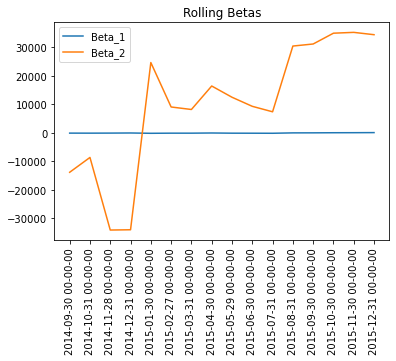

<Figure size 1440x144 with 0 Axes>

In [89]:
dependVar = sample_2['SMI Index']
independVar = sample_2[['CPI CHNG Index', 'USERTOT Index', 'NAPMNMI Index', 'CONSSENT Index', 'M2 Index']]

cdf = rolling_regression(dependVar,independVar,15)
cdf=pd.DataFrame.from_dict(OrderedDict(cdf), orient='index')
cdf['regressionId'] = 1
cdf.columns=["Beta_1","Beta_2","Beta_3", "Beta_4", "Beta_5", "RegressionId"]

plt.plot(cdf[["Beta_1", 'Beta_2']])
labels=["Beta_1","Beta_2","Beta_3", "Beta_4", "Beta_5"]
plt.legend(labels)
plt.title('Rolling Betas')
plt.xticks(rotation=90)
plt.figure(figsize=(20, 2))
plt.show
cdf.head(5)


# Check Correlation between the marco variables

In [263]:
corr = data[macroColumns].corr()

In [264]:
corr

,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
CPI CHNG Index,1.000000,0.116132,0.261534,0.348134,-0.012462,0.331547,0.147957,0.188202,-0.053499,-0.006298
USERTOT Index,0.116132,1.000000,0.544187,-0.107868,-0.052483,0.831195,-0.106354,0.436163,0.685385,0.582447
NAPMNMI Index,0.261534,0.544187,1.000000,0.066164,0.106342,0.658955,0.145218,0.383880,0.497433,0.437401
RSTAMOM Index,0.348134,-0.107868,0.066164,1.000000,0.044591,0.073242,0.023396,-0.003697,-0.060330,-0.042316
M2 Index,-0.012462,-0.052483,0.106342,0.044591,1.000000,0.151630,-0.029808,-0.494269,0.449316,0.676449
EUITEMU Index,0.331547,0.831195,0.658955,0.073242,0.151630,1.000000,0.058625,0.422658,0.611318,0.611709
CPMINORD Index,0.147957,-0.106354,0.145218,0.023396,-0.029808,0.058625,1.000000,0.278842,-0.089296,-0.049668
USGG10YR Index,0.188202,0.436163,0.383880,-0.003697,-0.494269,0.422658,0.278842,1.000000,0.150379,0.071142
CONSSENT Index,-0.053499,0.685385,0.497433,-0.060330,0.449316,0.611318,-0.089296,0.150379,1.000000,0.897165
CONCCONF Index,-0.006298,0.582447,0.437401,-0.042316,0.676449,0.611709,-0.049668,0.071142,0.897165,1.000000


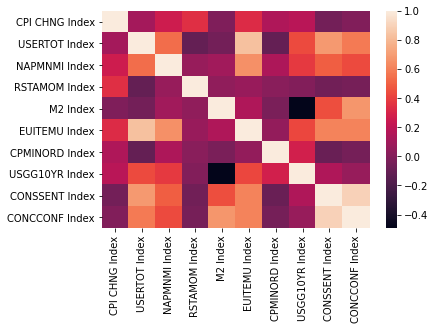

In [43]:
import seaborn as sns
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [112]:
data.corr()

,SMI Index,CCMP Index,DAX Index,UKX Index,EURUSD Curncy,CHFEUR Curncy,CHFUSD Curncy,CL1 Comdty,XAU Comdty,XAG Comdty,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
SMI Index,1.00000000,0.85252624,0.91683166,0.65640806,-0.64236175,0.60900490,-0.46198134,-0.65500845,-0.22577832,-0.74638721,-0.05590704,0.16871026,0.24984800,0.01874121,0.84218090,0.21784187,-0.04902877,-0.25057886,0.65103232,0.76401067
CCMP Index,0.85252624,1.00000000,0.84814942,0.44441586,-0.58308058,0.61209863,-0.33821945,-0.67430396,0.15399772,-0.49271543,0.04367929,-0.00296691,0.18383864,0.03936402,0.97978706,0.22572477,-0.00836088,-0.40032361,0.44943610,0.69057753
DAX Index,0.91683166,0.84814942,1.00000000,0.77752497,-0.71170820,0.66810674,-0.51729559,-0.71185141,-0.29915385,-0.73662852,0.05443703,0.30423611,0.36772927,0.04562340,0.83234983,0.45431178,0.04915623,-0.11828589,0.76500611,0.87060275
UKX Index,0.65640806,0.44441586,0.77752497,1.00000000,-0.45347242,0.28357985,-0.49280250,-0.29626277,-0.57011323,-0.66723307,0.07460873,0.61519100,0.43749937,0.02989406,0.39671235,0.61565339,0.13247677,0.34341108,0.81014185,0.82267272
EURUSD Curncy,-0.64236175,-0.58308058,-0.71170820,-0.45347242,1.00000000,-0.87087510,0.82222444,0.88951560,0.33398271,0.74974464,0.14527574,-0.29623974,-0.14740532,0.02666107,-0.65410172,-0.29892779,0.19533315,0.36967596,-0.73509335,-0.73243867
CHFEUR Curncy,0.60900490,0.61209863,0.66810674,0.28357985,-0.87087510,1.00000000,-0.43887628,-0.87887762,-0.12516953,-0.55839453,-0.09607041,0.08659723,0.05802955,-0.02329468,0.67887982,0.15551405,-0.21223057,-0.49963845,0.52019048,0.55731961
CHFUSD Curncy,-0.46198134,-0.33821945,-0.51729559,-0.49280250,0.82222444,-0.43887628,1.00000000,0.60619774,0.48064983,0.71821713,0.15128977,-0.43342940,-0.18956213,0.02210407,-0.39233526,-0.34935554,0.11257532,0.08610286,-0.73648066,-0.68195707
CL1 Comdty,-0.65500845,-0.67430396,-0.71185141,-0.29626277,0.88951560,-0.87887762,0.60619774,1.00000000,0.17527054,0.65034552,0.18242528,-0.09557031,-0.06440545,0.07249292,-0.75328540,-0.19211454,0.15438263,0.47739429,-0.56996821,-0.63295215
XAU Comdty,-0.22577832,0.15399772,-0.29915385,-0.57011323,0.33398271,-0.12516953,0.48064983,0.17527054,1.00000000,0.67371074,0.11568057,-0.55151453,-0.34970736,0.06530789,0.14367140,-0.40049433,-0.05859392,-0.57882718,-0.63429698,-0.43263051
XAG Comdty,-0.74638721,-0.49271543,-0.73662852,-0.66723307,0.74974464,-0.55839453,0.71821713,0.65034552,0.67371074,1.00000000,0.23555951,-0.38014184,-0.24046322,0.06100472,-0.54089209,-0.28497982,0.11148923,0.02085419,-0.80580717,-0.77136674
